In [ ]:
import numpy as np
from pydrake.all import (
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    BsplineTrajectory,
    DiagramBuilder,
    KinematicTrajectoryOptimization,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MinimumDistanceLowerBoundConstraint,
    Parser,
    PositionConstraint,
    Rgba,
    RigidTransform,
    RotationMatrix,
    Role,
    Solve,
    Sphere,
    StartMeshcat,
)

from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddPlanarIiwa, AddWsg
from manipulation.utils import ConfigureParser, RenderDiagram
from pydrake.systems.analysis import Simulator
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.station import LoadScenario, MakeHardwareStation, MakeMultibodyPlant
from manipulation.scenarios import AddMultibodyTriad
from pydrake.multibody.plant import MultibodyPlant

In [3]:
# import numpy as np
# from pydrake.all import (
#     ConstantVectorSource,
#     DiagramBuilder,
#     MultibodyPlant,
#     Parser,
#     PiecewisePolynomial,
#     PiecewiseQuaternionSlerp,
#     RigidTransform,
#     RollPitchYaw,
#     RotationMatrix,
#     Simulator,
#     Solve,
#     StartMeshcat,
#     TrajectorySource,
# )
# from pydrake.multibody import inverse_kinematics
# from pydrake.trajectories import PiecewisePolynomial

# from manipulation.meshcat_utils import AddMeshcatTriad
# from manipulation.scenarios import AddMultibodyTriad
# from manipulation.station import LoadScenario, MakeHardwareStation, MakeMultibodyPlant
# from manipulation.utils import FindResource

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


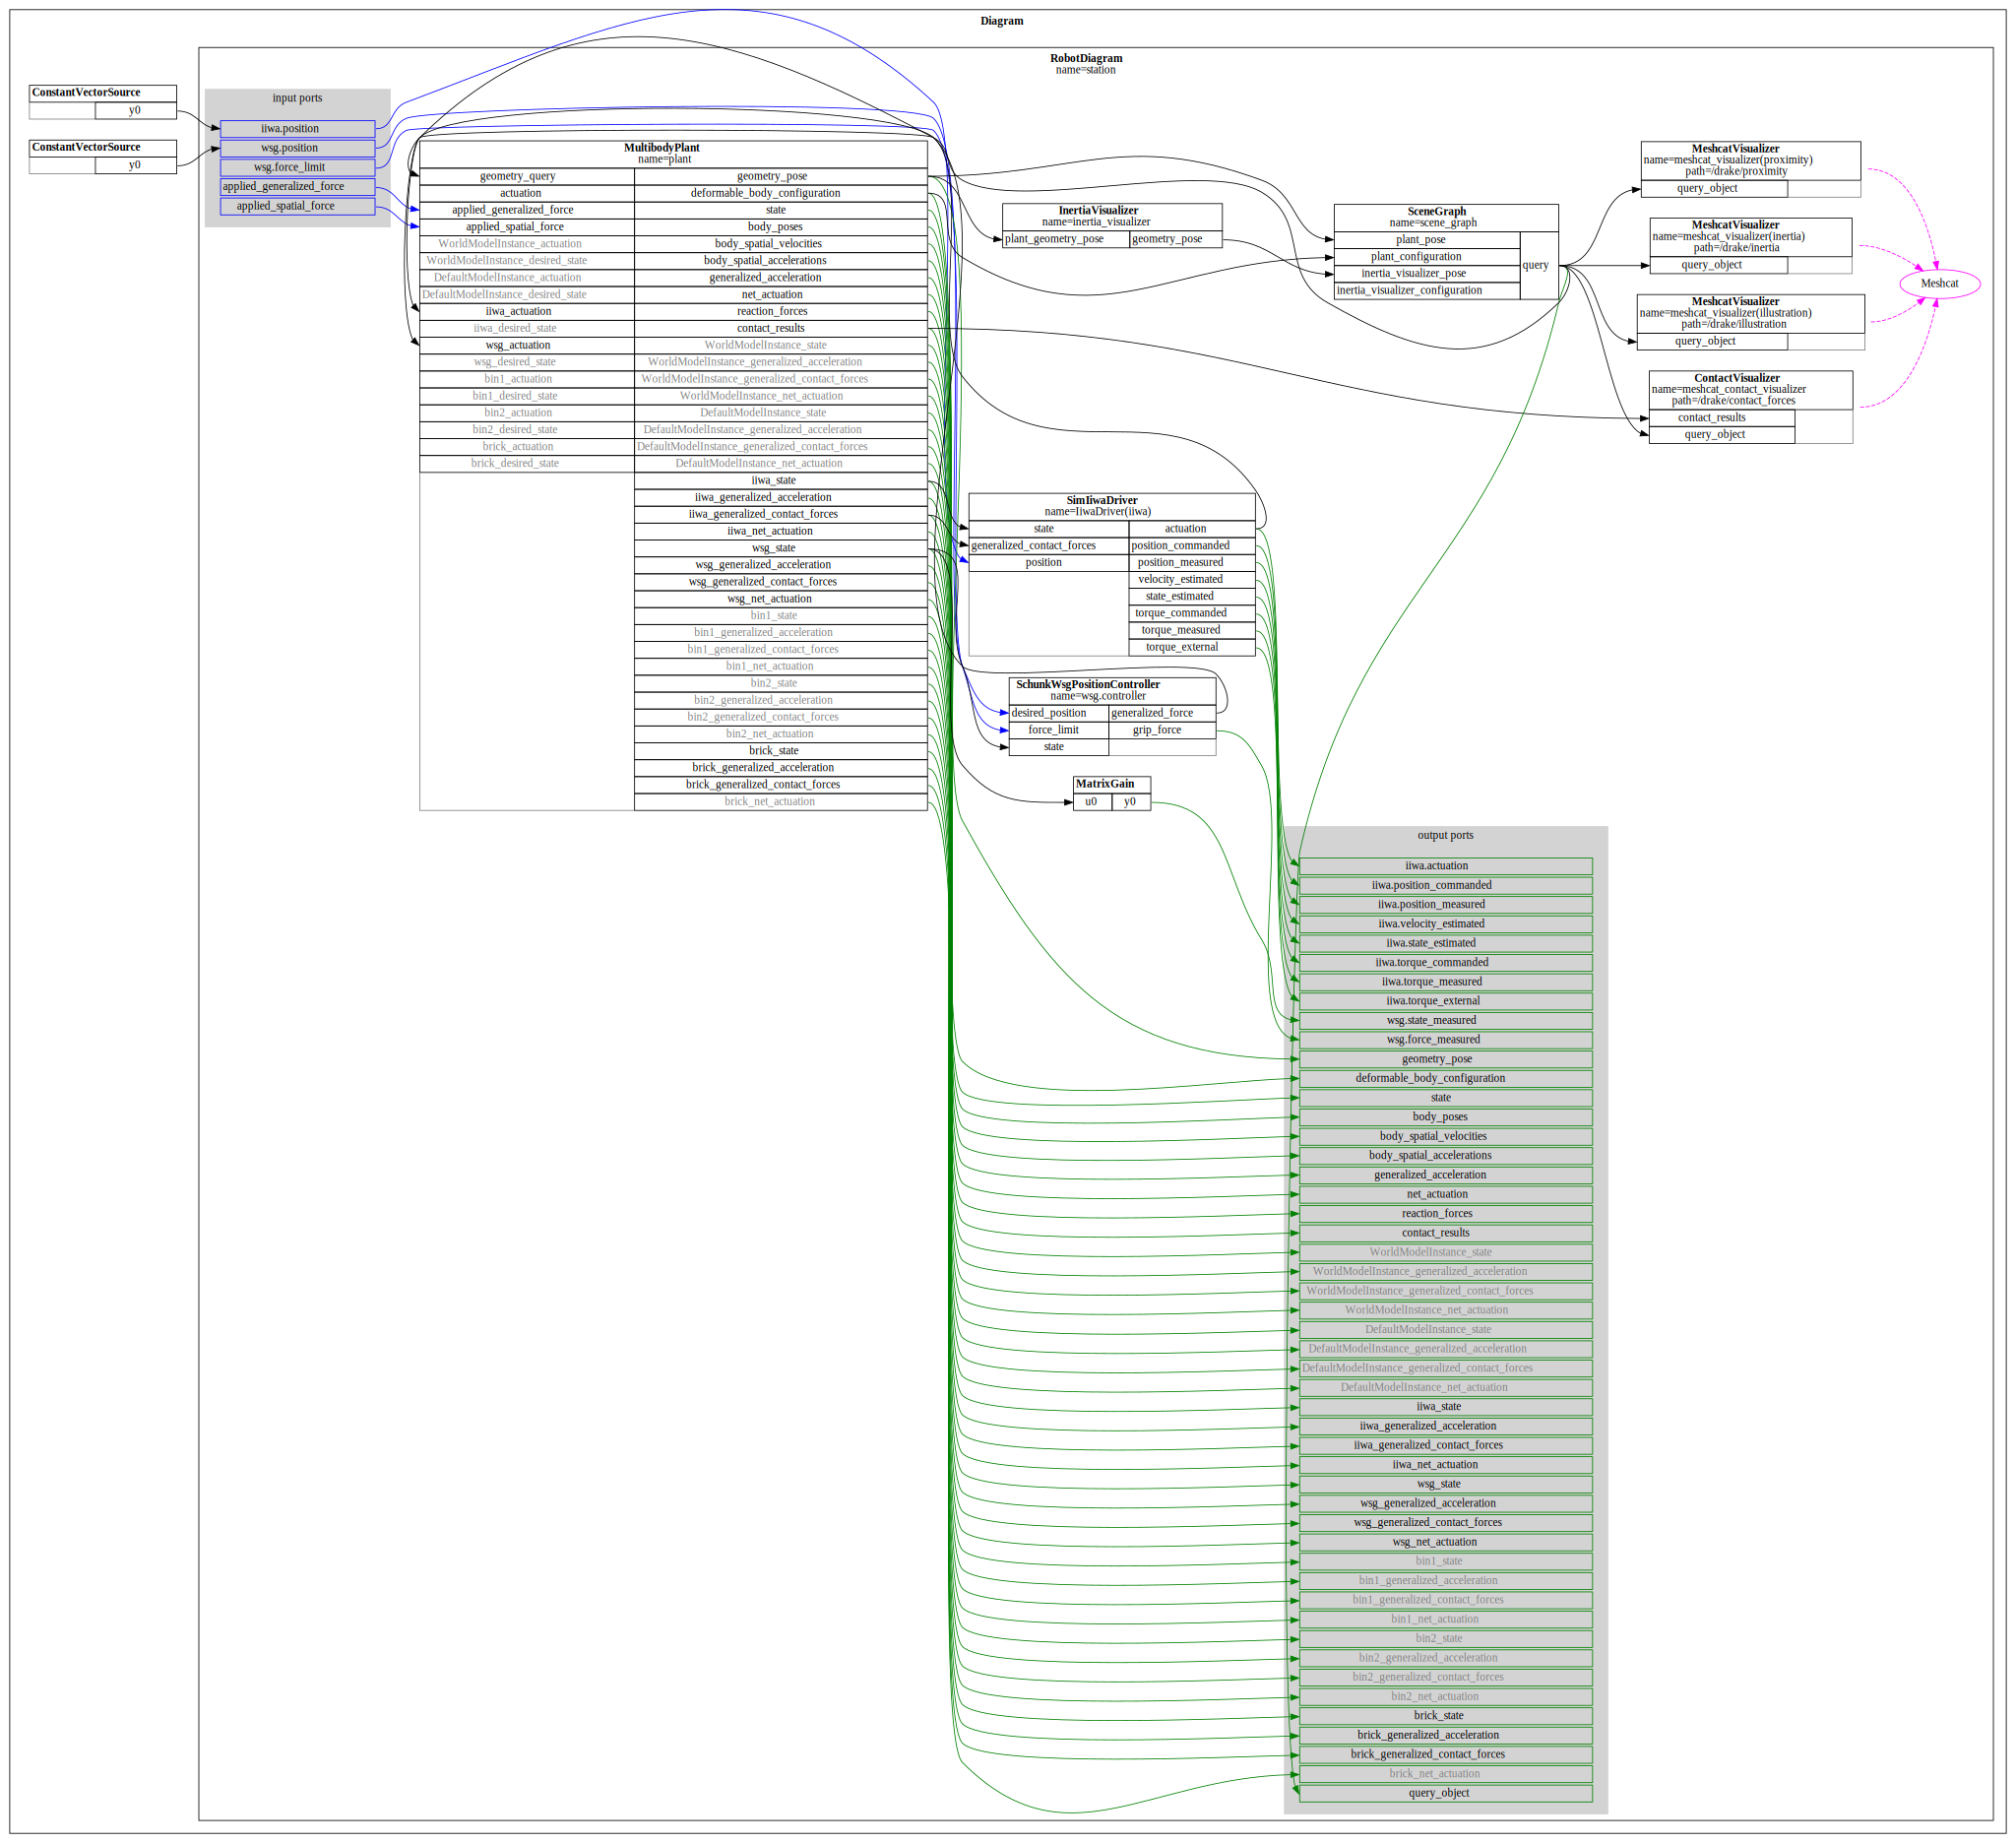

In [19]:
def setup_manipulation_station():
    ## long way ##
    # meshcat.Delete()
    # meshcat.DeleteAddedControls()
    # builder = DiagramBuilder()

    # plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    # iiwa = AddPlanarIiwa(plant)
    # wsg = AddWsg(plant, iiwa, roll=0.0, welded=True, sphere=True)
    
    # parser = Parser(plant)
    # ConfigureParser(parser)
    
    # bin = parser.AddModelsFromUrl("package://manipulation/shelves.sdf")[0]
    # plant.WeldFrames(
    #     plant.world_frame(),
    #     plant.GetFrameByName("shelves_body", bin),
    #     RigidTransform([0.88, 0, 0.4]),
    # )
    
    # plant.Finalize()

    ######

    builder = DiagramBuilder()
    scenario = LoadScenario(filename="project.yaml")
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))
    plant = station.GetSubsystemByName("plant")
    scene_graph = station.GetSubsystemByName("scene_graph")
    # Ensure scene_graph is explicitly added
    AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)

    iiwa_position = builder.AddSystem(ConstantVectorSource(np.zeros(7)))
    builder.Connect(
        iiwa_position.get_output_port(), station.GetInputPort("iiwa.position")
    )

    wsg_position = builder.AddSystem(ConstantVectorSource([0.06]))
    builder.Connect(
        wsg_position.get_output_port(), station.GetInputPort("wsg.position")
    )

    # visualizer = MeshcatVisualizer.AddToBuilder(
    #     builder,
    #     scene_graph,  # Explicitly reference scene_graph
    #     meshcat,
    #     MeshcatVisualizerParams(role=Role.kIllustration),
    # )


    # collision_visualizer = MeshcatVisualizer.AddToBuilder(
    #     builder,
    #     scene_graph,
    #     meshcat,
    #     MeshcatVisualizerParams(
    #         prefix="collision", role=Role.kProximity, visible_by_default=False
    #     ),
    # )

    diagram = builder.Build()

    context = plant.CreateDefaultContext()
    gripper = plant.GetBodyByName("body")

    initial_pose = plant.EvalBodyPoseInWorld(context, gripper)

    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    
    context = simulator.get_mutable_context()
    simulator.AdvanceTo(0.01)

    # Get the pose of the brick model in the world frame
    # Get the final pose of the brick
    plant_context = plant.GetMyContextFromRoot(context)

    # brick_body = plant.GetBodyByName("base_link", model_instance=plant.GetModelInstanceByName("brick"))
    # final_pose = plant.EvalBodyPoseInWorld(plant_context, brick_body)
    # print(final_pose)

    return diagram

diagram = setup_manipulation_station()

RenderDiagram(diagram, max_depth=2)
# def run_simulation():
#     diagram = setup_manipulation_station()
#     simulator = Simulator(diagram)
#     meshcat.StartRecording()
#     simulator.AdvanceTo(2.0)
#     meshcat.PublishRecording()

# # Get initial pose of the gripper by using default context of manip station.
# run_simulation()

In [20]:
def CreateIiwaControllerPlant():
    """creates plant that includes only the robot and gripper, used for controllers."""
    scenario = LoadScenario(filename="project.yaml")
    plant_robot = MakeMultibodyPlant(
        scenario=scenario, model_instance_names=["iiwa", "wsg"]
    )

    # print("Number of positions:", plant_robot.num_positions())
    # print("Number of velocities:", plant_robot.num_velocities())
    # print("lower: ", plant_robot.GetVelocityLowerLimits())
    # print("Lower velocity bounds size:", len(plant_robot.GetVelocityLowerLimits()))
    # print("Upper velocity bounds size:", len(plant_robot.GetVelocityUpperLimits()))
    # print("plant.GetPositionLowerLimits(): ", plant_robot.GetPositionLowerLimits())

    link_frame_indices = []
    for i in range(8):
        link_frame_indices.append(
            plant_robot.GetFrameByName("iiwa_link_" + str(i)).index()
        )

    return plant_robot, link_frame_indices
CreateIiwaControllerPlant()

(<pydrake.multibody.plant.MultibodyPlant at 0x73017f320890>,
 [FrameIndex(1),
  FrameIndex(2),
  FrameIndex(3),
  FrameIndex(4),
  FrameIndex(5),
  FrameIndex(6),
  FrameIndex(7),
  FrameIndex(8)])

In [23]:
def move(diagram):
    # Get the station subsystem
    station = diagram.GetSubsystemByName("station")
    
    # Get the MultibodyPlant subsystem
    plant = station.GetSubsystemByName("plant")
    
    # visualizer = diagram.GetSubsytemByName("visualizer")
    
    plant, _ = CreateIiwaControllerPlant()
    context = plant.CreateDefaultContext()
    
    # Create a context for the diagram
    diagram_context = diagram.CreateDefaultContext()
    
    # Get the plant-specific context
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    
    # Retrieve the number of positions and joint positions
    num_q = plant.num_positions()
    print("num_q: ", num_q)
    
    q0 = plant.GetPositions(context)
    print("q0: ", q0)
    
    wsg = plant.GetModelInstanceByName("wsg")
    gripper_frame = plant.GetFrameByName("body", wsg)
    # print(gripper_frame)

    gripper = plant.GetBodyByName("body")
    X_WStart = plant.EvalBodyPoseInWorld(context, gripper)
    # print(X_WStart)

    print("Number of positions:", plant.num_positions())
    print("Number of velocities:", plant.num_velocities())
    print("lower: ", plant.GetVelocityLowerLimits())
    print("Lower velocity bounds size:", len(plant.GetVelocityLowerLimits()))
    print("Upper velocity bounds size:", len(plant.GetVelocityUpperLimits()))
    print("plant.GetPositionLowerLimits(): ", plant.GetPositionLowerLimits())
    trajopt = KinematicTrajectoryOptimization(num_q, 10)

    # RenderDiagram(diagram, max_depth=2)

    prog = trajopt.get_mutable_prog()
    trajopt.AddDurationCost(1.0)
    trajopt.AddPathLengthCost(1.0)
    trajopt.AddPositionBounds(
        plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()
    )

    vel_lower_limits = plant.GetVelocityLowerLimits()
    vel_upper_limits = plant.GetVelocityUpperLimits()
    vel_lower_limits[7] = -0.025
    vel_upper_limits[7] = 0.025
    vel_lower_limits[8] = -0.025
    vel_upper_limits[8] = 0.025
    # print("type: ", type(vel_lower_limits))
    # .append(-np.inf) 
    # trajopt.AddVelocityBounds(
    #     plant.GetVelocityLowerLimits(), plant.GetVelocityUpperLimits()
    # )
    trajopt.AddVelocityBounds(
        vel_lower_limits, vel_upper_limits
    )

    trajopt.AddDurationConstraint(0.5, 5)

    
    start_constraint = PositionConstraint(
        plant,
        plant.world_frame(),
        X_WStart.translation(),
        X_WStart.translation(),
        gripper_frame,
        [0, 0.1, 0],
        context,
    )

    trajopt.AddPathPositionConstraint(start_constraint, 0)
    prog.AddQuadraticErrorCost(np.eye(num_q), q0, trajopt.control_points()[:, 0])

    p0 = [0.7, 0.0, 0.565]
    # R0 = RotationMatrix(np.array([[0, 1, 0], [0, 0, -1], [-1, 0, 0]]).T)
    X_WGoal = RigidTransform(p0)

    # goal constraint
    goal_constraint = PositionConstraint(
        plant,
        plant.world_frame(),
        X_WGoal.translation(),
        X_WGoal.translation(),
        gripper_frame,
        [0, 0.1, 0],
        context,
    )

    trajopt.AddPathPositionConstraint(goal_constraint, 1)
    prog.AddQuadraticErrorCost(np.eye(num_q), q0, trajopt.control_points()[:, -1])
    # start and end with zero velocity
    trajopt.AddPathVelocityConstraint(np.zeros((num_q, 1)), np.zeros((num_q, 1)), 0)
    trajopt.AddPathVelocityConstraint(np.zeros((num_q, 1)), np.zeros((num_q, 1)), 1)

    # Solve once without the collisions and set that as the initial guess for
    # the version with collisions.
    result = Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions!")
        print(result.get_solver_id().name())
    # trajopt.SetInitialGuess(trajopt.ReconstructTrajectory(result))

    avoid_collisions = False

    if avoid_collisions:
        # collision constraints
        collision_constraint = MinimumDistanceLowerBoundConstraint(
            plant, 0.01, plant_context, None, 0.1
        )
        evaluate_at_s = np.linspace(0, 1, 25)
        for s in evaluate_at_s:
            trajopt.AddPathPositionConstraint(collision_constraint, s)

        result = Solve(prog)
        if not result.is_success():
            print("Trajectory optimization failed")
            print(result.get_solver_id().name())
    
    # PublishPositionTrajectory(
    #     trajopt.ReconstructTrajectory(result), context, plant, visualizer
    # )
    # collision_visualizer.ForcedPublish(
    #     collision_visualizer.GetMyContextFromRoot(context)
    # )
    
    return result

result = move(diagram)

num_q:  9
q0:  [ 0.    0.6   0.   -1.75  0.    1.    0.    0.    0.  ]
Number of positions: 9
Number of velocities: 9
lower:  [-1.71042267 -1.71042267 -1.74532925 -2.26892803 -2.44346095 -3.14159265
 -3.14159265        -inf        -inf]
Lower velocity bounds size: 9
Upper velocity bounds size: 9
plant.GetPositionLowerLimits():  [-2.96706 -2.0944  -2.96706 -2.0944  -2.96706 -2.0944  -3.05433 -0.055
  0.     ]


In [28]:
result.GetSolution()

array([ 0.        ,  0.39554116,  0.        , -1.74697252,  0.        ,
        1.0681773 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.39554116,  0.        , -1.74697252,  0.        ,  1.0681773 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.35017729,
        0.        , -1.63892833,  0.        ,  1.00398713,  0.        ,
        0.        ,  0.        ,  0.        ,  0.32769119,  0.        ,
       -1.58537303,  0.        ,  0.97216945,  0.        ,  0.        ,
        0.        ,  0.        ,  0.30119628,  0.        , -1.52227052,
        0.        ,  0.93467996,  0.        ,  0.        ,  0.        ,
        0.        ,  0.26584965,  0.        , -1.4380861 ,  0.        ,
        0.88466587,  0.        ,  0.        ,  0.        ,  0.        ,
        0.23576967,  0.        , -1.36644431,  0.        ,  0.84210354,
        0.        ,  0.        ,  0.        ,  0.        ,  0.21394842,
        0.        , -1.31447175,  0.        ,  0.8112267 ,  0.  

In [8]:
def run_simulation():
    # Set up the manipulation station diagram
    diagram = setup_manipulation_station()

    # Create a simulator for the diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Get the station and plant from the diagram
    station = diagram.GetSubsystemByName("station")
    plant = station.GetSubsystemByName("plant")

    # Solve the trajectory optimization before running the simulation
    trajopt = move(diagram)  # Call move() to optimize trajectory and return it
    if trajopt is None:
        print("Failed to compute trajectory. Exiting simulation.")
        return

    trajectory = trajopt.ReconstructTrajectory(Solve(trajopt.get_mutable_prog()))

    # Start recording in Meshcat
    meshcat.StartRecording()

    # Simulate the trajectory
    simulation_duration = trajectory.end_time()
    print(simulation_duration)
    simulator.set_target_realtime_rate(1.0)
    
    # Publish trajectory to Meshcat
    PublishPositionTrajectory(trajectory, context, plant, meshcat)

    # Advance simulation
    print(f"Running simulation for {simulation_duration:.2f} seconds...")
    simulator.Initialize()
    simulator.AdvanceTo(2.0)

    # Publish recorded visualization
    meshcat.PublishRecording()
    print("Simulation complete and visualized in Meshcat.")

In [9]:
trajopt = move(diagram)  # Call move() to optimize trajectory and return it
if trajopt is None:
    print("Failed to compute trajectory. Exiting simulation.")


num_q:  9
q0:  [ 0.    0.6   0.   -1.75  0.    1.    0.    0.    0.  ]
Number of positions: 9
Number of velocities: 9
lower:  [-1.71042267 -1.71042267 -1.74532925 -2.26892803 -2.44346095 -3.14159265
 -3.14159265        -inf        -inf]
Lower velocity bounds size: 9
Upper velocity bounds size: 9
plant.GetPositionLowerLimits():  [-2.96706 -2.0944  -2.96706 -2.0944  -2.96706 -2.0944  -3.05433 -0.055
  0.     ]


In [ ]:
trajectory = trajopt.ReconstructTrajectory(Solve(trajopt.get_mutable_prog()))

: 

In [18]:
def list_subsystems(diagram):
    subsystems = diagram.GetSystems()  # Get all subsystems in the diagram
    for i, subsystem in enumerate(subsystems):
        print(f"Subsystem {i}: {subsystem.get_name()} (Type: {type(subsystem)})")
    return subsystems

# Example usage
subsystems = list_subsystems(diagram)

Subsystem 0: station (Type: <class 'pydrake.planning.RobotDiagram'>)
Subsystem 1: drake/systems/ConstantVectorSource@00005a0c1fcbca50 (Type: <class 'pydrake.systems.primitives.ConstantVectorSource'>)
Subsystem 2: drake/systems/ConstantVectorSource@00005a0c1f970c30 (Type: <class 'pydrake.systems.primitives.ConstantVectorSource'>)


In [ ]:


AddMeshcatTriad(meshcat, "f0", length=0.15, radius=0.006, X_PT=X_WF)

In [20]:
0.54+0.025

0.5650000000000001

In [9]:
def create_scene(sim_time_step):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=sim_time_step)
    
    parser = Parser(plant)
    ConfigureParser(parser)

    iiwa = AddPlanarIiwa(plant)
    wsg = AddWsg(plant, iiwa, roll=0.0, welded=True, sphere=True)
    # X_WStart = RigidTransform([0.8, 0, 0.65])
    # meshcat.SetObject("start", Sphere(0.02), rgba=Rgba(0.9, 0.1, 0.1, 1))
    # meshcat.SetTransform("start", X_WStart)
    # X_WGoal = RigidTransform([0.8, 0, 0.4])
    # meshcat.SetObject("goal", Sphere(0.02), rgba=Rgba(0.1, 0.9, 0.1, 1))
    # meshcat.SetTransform("goal", X_WGoal)

    parser.SetAutoRenaming(True)
    bin1 = parser.AddModelsFromUrl("package://manipulation/shelves.sdf")[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("shelves_body", bin1),
        RigidTransform([0.88, 0, 0.4]),
    )

    # Add the second shelf
    bin2 = parser.AddModelsFromUrl("package://manipulation/shelves.sdf")[0]
    X_WBin2 = RigidTransform(
        RotationMatrix.MakeZRotation(np.pi),  # 180° rotation about z-axis
        [-0.8, 0, 0.4],  # Position of the second shelf
    )
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("shelves_body", bin2),
        X_WBin2,
    )

    brick = parser.AddModelsFromUrl("package://drake_models/manipulation_station/061_foam_brick.sdf")[0]
    brick_body = plant.GetBodyByName("base_link", brick)
    
    # # Set the default pose of the brick
    X_WBrick = RigidTransform(
        # RotationMatrix.MakeZRotation(np.pi / 4),  # Example orientation: 45° rotation about the z-axis
        [0.8, 0., 0.6])
    plant.SetDefaultFreeBodyPose(brick_body, X_WBrick)

    plant.Finalize()

    AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()
    return diagram

def run_simulation(sim_time_step):
    diagram = create_scene(sim_time_step)
    simulator = Simulator(diagram)
    meshcat.StartRecording()
    simulator.AdvanceTo(5.0)
    meshcat.PublishRecording()


run_simulation(0.001)